In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# Load your dataset
df = pd.read_csv('data/earthquake_data.csv')

# Drop duplicates and handle missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['Magnitude', 'Epoch(UTC)', 'Lat', 'Lon', 'Depth Km'], inplace=True)

# Convert time fields
df['Epoch(UTC)'] = pd.to_datetime(df['Epoch(UTC)'], unit='s')
df['Time UTC'] = pd.to_datetime(df['Time UTC'], errors='coerce')
df = df.dropna(subset=['Time UTC'])


In [3]:
df['Year'] = df['Epoch(UTC)'].dt.year
df['Month'] = df['Epoch(UTC)'].dt.month
df['DayOfYear'] = df['Epoch(UTC)'].dt.dayofyear

from sklearn.cluster import DBSCAN
coords = df[['Lat', 'Lon']]
db = DBSCAN(eps=0.5, min_samples=5).fit(coords)
df['Cluster'] = db.labels_

# Magnitude binning
df['MagnitudeBin'] = pd.cut(df['Magnitude'], bins=[0, 3, 5, 7, 10], labels=['Micro', 'Minor', 'Moderate', 'Strong'])

# Target variable: Will an earthquake occur in next X years?
def label_future_quakes(df, years=2):
    df = df.sort_values('Epoch(UTC)')
    df['FutureQuake'] = 0
    for i in range(len(df)):
        current_time = df.iloc[i]['Epoch(UTC)']
        future_window = current_time + pd.DateOffset(years=years)
        future_events = df[(df['Epoch(UTC)'] > current_time) & (df['Epoch(UTC)'] <= future_window)]
        df.at[df.index[i], 'FutureQuake'] = int(len(future_events) > 0)
    return df

df = label_future_quakes(df, years=2)  # Repeat for 5 and 10 years

Text(0.5, 1.0, 'Magnitude Count')

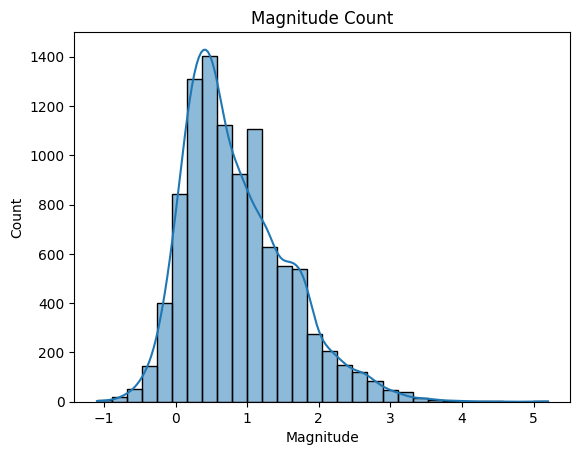

In [8]:
# Magnitude distribution
sns.histplot(df['Magnitude'], bins=30, kde=True).set_title("Magnitude Count")

Text(0.5, 1.0, 'Magnitude vs Depth km')

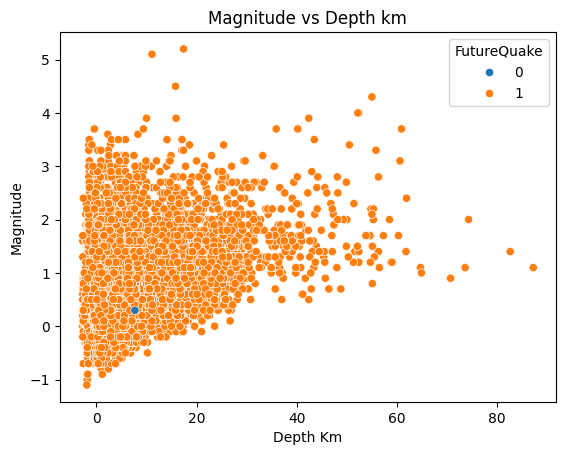

In [9]:
# Depth vs Magnitude
sns.scatterplot(x='Depth Km', y='Magnitude', hue='FutureQuake', data=df).set_title("Magnitude vs Depth km")

Text(0.5, 1.0, 'Features Related to Earthquake Activity')

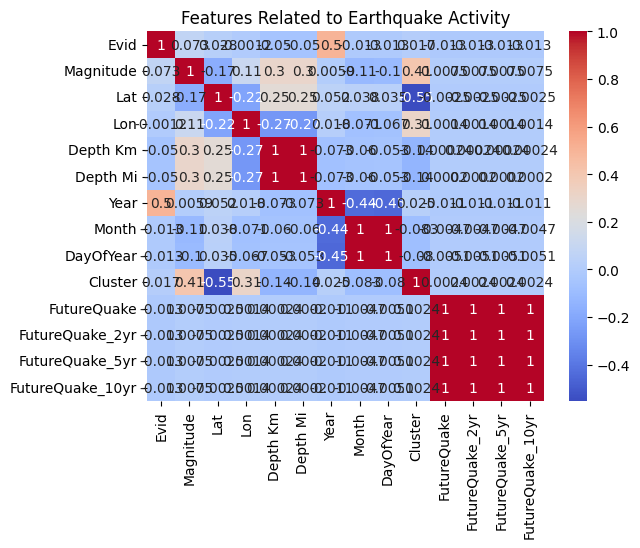

In [10]:
# Correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm').set_title("Features Related to Earthquake Activity")

In [12]:
# Select features
features = ['Magnitude', 'Depth Km', 'Lat', 'Lon', 'Year', 'Month', 'DayOfYear']
X = df[features]
y = df['FutureQuake']

# Removes classes that have single instances
value_counts = y.value_counts()
valid_classes = value_counts[value_counts > 1].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Dynamically generates new target columns
for years in [2, 5, 10]:
    df[f'FutureQuake_{years}yr'] = label_future_quakes(df.copy(), years=years)['FutureQuake']

# Evaluate
y_pred = model.predict(X_test)
print("Model Performance on DataSet")
print(classification_report(y_test, y_pred))

Model Performance on DataSet
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

